<a href="https://colab.research.google.com/github/ismailsangu/IE423-TASK/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediciton of cuatomer purchase amount in Black Friday:

## Initialize

In [26]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dfBF = pd.read_csv('/content/drive/MyDrive/Data_Sets/train.csv')

# Select target as a series and features as dataframe
y = dfBF.loc[:,['Purchase']].values.ravel()
X = dfBF.drop(['Purchase'],axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2,random_state=1)

In [6]:
dfBF.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [7]:
dfBF.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [8]:
dfBF.duplicated().value_counts()

False    550068
Name: count, dtype: int64

## Build Random Forest Model

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Function for building and scoring Random Forest models
def get_random_forest_mae(X_trn, X_tst, y_trn, y_tst):
    mdlRfsBF = RandomForestRegressor(random_state=1)
    mdlRfsBF.fit(X_trn, y_trn)
    y_tst_prd = mdlRfsBF.predict(X_tst)
    mae = mean_absolute_error(y_tst, y_tst_prd)
    return (mae)

Let's try to build a model with all the features...

In [10]:
# Try to build a model using all features
get_random_forest_mae(X_train, X_test, y_train, y_test)

ValueError: could not convert string to float: 'P00304042'

Seems like some of the columns are non-numeric.  So, we have to use different methods to deal with them.

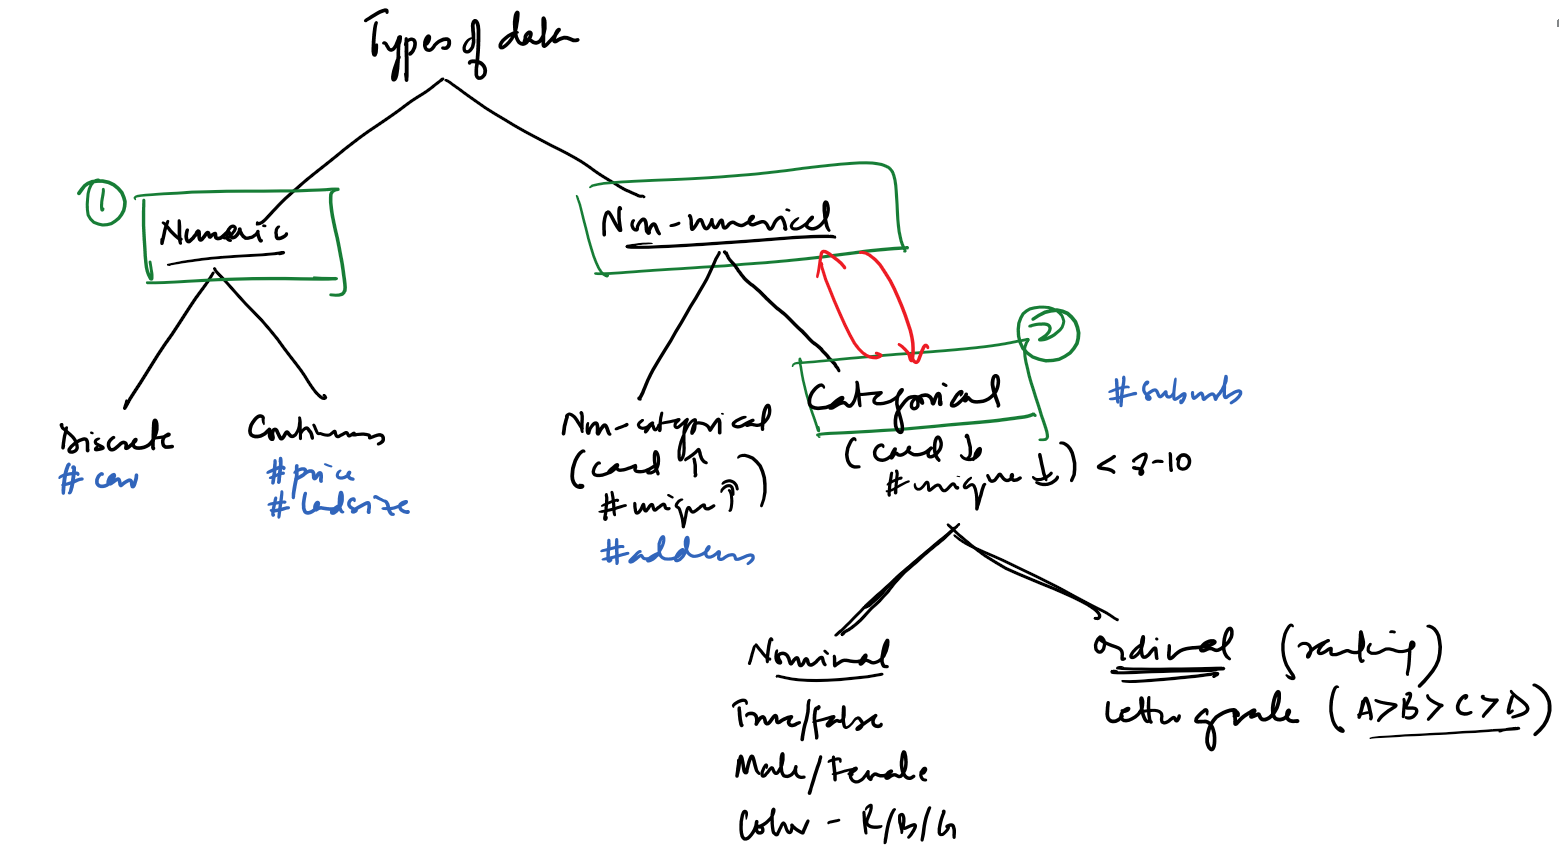

## Numerical Features
Columns with quantitative data - either Discrete or Continuous are called Numerical Features.

In [11]:
# Select numeric features
cols_num = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
Xnum = X[cols_num]

# Split numeric features into training and test sets
Xnum_train, Xnum_test, y_train, y_test = train_test_split(Xnum,y,train_size=0.8, test_size=0.2,random_state=1)

In [12]:
# Try to build a model using all numeric features
get_random_forest_mae(Xnum_train, Xnum_test, y_train, y_test)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Seems like some of the numeric columns have **Missing Values**.

In [13]:
# Count number of missing values in each column of the training data
Xnum_train.isna().sum()

User_ID                    0
Occupation                 0
Marital_Status             0
Product_Category_1         0
Product_Category_2    138892
Product_Category_3    306504
dtype: int64

As expected, there are some missing values in Product_Category_2 and Product_Category_3.



#### Approach 1. Drop columns with missing values
The simplest option is to **drop columns** with missing values.

In [14]:
# Identify columns with missing values and then drop such columns
cols_num_null = [col for col in Xnum_train.columns
    if Xnum_train[col].isnull().any()]
Xnum_train_drpnull = Xnum_train.drop(cols_num_null, axis=1)
Xnum_test_drpnull = Xnum_test.drop(cols_num_null, axis=1)

In [15]:
print('MAE from Approach 1 (Drop features with missing values):')
print(get_random_forest_mae(Xnum_train_drpnull, Xnum_test_drpnull, y_train, y_test))

MAE from Approach 1 (Drop features with missing values):
2091.2402741391948


#### Approach 2. Fill missing values by Imputation
**Imputation** fills in the missing values with some number. For instance, we can fill in the mean value along each column.

In [16]:
# Replace with specific value (0, bfill, ffill)
Xnum_train_repnull = Xnum_train.fillna(method = 'ffill')
Xnum_test_repnull = Xnum_test.fillna(method = 'ffill')

print('MAE from Approach 2 (Replace missing values with forward fill):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

MAE from Approach 2 (Replace missing values with forward fill):


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

The NaN values prevent the model from work truely so we have to replace all NaN values with 0.

In [18]:
# Replace with specific value (0, bfill, ffill)
Xnum_train_repnull = Xnum_train.fillna(method = 'ffill')
Xnum_test_repnull = Xnum_test.fillna(method = 'ffill')

# Fill any remaining NaNs with 0
Xnum_train_repnull = Xnum_train_repnull.fillna(0)  # Fill remaining NaNs with 0
Xnum_test_repnull = Xnum_test_repnull.fillna(0)    # Fill remaining NaNs with 0

# Verify if NaNs still exist
print("Remaining NaNs in Xnum_train_repnull:", Xnum_train_repnull.isna().sum().sum())
print("Remaining NaNs in Xnum_test_repnull:", Xnum_test_repnull.isna().sum().sum())

print('MAE from Approach 2 (Replace missing values with forward fill):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

Remaining NaNs in Xnum_train_repnull: 0
Remaining NaNs in Xnum_test_repnull: 0
MAE from Approach 2 (Replace missing values with forward fill):
2272.0611026771116


In [19]:
# Replace with mean value
Xnum_train_repnull = Xnum_train.fillna(Xnum_train.mean())
Xnum_test_repnull = Xnum_test.fillna(Xnum_train.mean())

print('MAE from Approach 2 (Replace missing values with mean):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

MAE from Approach 2 (Replace missing values with mean):
2193.456214200903


Filling with mean value makes result better but dropping columns still have  better result than filling method because the number of dropped columns is not much to increase error.

In [20]:
# Going forward, let us replace all missing numeric values with the column mean
X_train[cols_num]=Xnum_train_repnull[cols_num]
X_test[cols_num]=Xnum_test_repnull[cols_num]

Next, let's try to improve the model by including some non-numeric features...

utexas_ds_orie_divider_gray.png

## Non-numerical Features

We have already seen the error generated by non-numeric features, but let's try to convert them to numeric values so that they can be used in the model.

In [21]:
# Select non-numeric features
cols_obj = [col for col in X.columns if X[col].dtype == 'object']
cols_obj

['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [22]:
# Label encoding on all non-numeric features

from sklearn.preprocessing import LabelEncoder

Xle_train = X_train.copy()
Xle_test = X_test.copy()
# Apply label encoder to each column with non-numeric data
label_encoder = LabelEncoder()
for col in cols_obj:
    Xle_train[col] = label_encoder.fit_transform(X_train[col])
    Xle_test[col] = label_encoder.transform(X_test[col])

ValueError: y contains previously unseen labels: 'P00206242'

There are too many values to be label encoded.  So, we would need to take only those non-numeric features with low cardinality aka **Categorical features**.

In [23]:
# Select categorical features
cols_cat = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique()<10]
cols_cat

['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [24]:
# Label encoding on only categorical features

from sklearn.preprocessing import LabelEncoder

Xle_train = X_train.copy()
Xle_test = X_test.copy()
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cols_cat:
    Xle_train[col] = label_encoder.fit_transform(X_train[col])
    Xle_test[col] = label_encoder.transform(X_test[col])

In [25]:
# Encode and Build/Score using all Categorical columns

mae = get_random_forest_mae(Xle_train[cols_num + cols_cat], Xle_test[cols_num + cols_cat], y_train, y_test)
print("MAE from Label Encoding all Categorical columns:")
print(mae)

MAE from Label Encoding all Categorical columns:
2154.210619732392


The result becomes worse when converting non-numeric values to numeric values. This is probably because missing values in non numeric values increase the error by turning them into numeric values.

## Build Gradient Boosted Tree Model

Let's begin by training a simple Gradient Boosting model...

In [27]:
from xgboost import XGBRegressor

#Build and score default Gradient Boosting Model
mdlXgbBF = XGBRegressor()
mdlXgbBF.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbBF.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from default XGBoost model:")
print(mae)

MAE from default XGBoost model:
2090.9818629360047


 The result here is best. However, we can still try to improve this by **tuning the parameters** that drive the Gradient Boosting model.  Below are some popular parameters...

`n_estimators`: maximum number of decision trees that will be ensembled

`max_depth`: maximum depth of each tree (typically 3-10)

`learning_rate`: weight applied to each tree (typically 0.01-0.2)

In [29]:
#Build and score a tuned Gradient Boosting Model
mdlXgbBF = XGBRegressor(n_estimators=5000, learning_rate=0.01, max_depth=5)
mdlXgbBF.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbBF.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from tuned XGBoost model:")
print(mae)

MAE from tuned XGBoost model:
2100.3951026451473


Ironically, instead tuned model improves the result of the default one, it results worse.

## Conclusion

* The first problem was non-numeric columns so we used model with only numeric features.
* The second problem was missing values in numeric features. We used two different method, dropping column and filling missing values, to solve it by random forest model and dropping column had a better result.  
* Label encoding is also used in random forest model but it had worse result.
* Ensembled many decision trees more intelligently using the *Gradient Boosting* model and it had a best result. However, *Parameter Tuning* had a worse result instead of improving.
* Shortly, the best result recorded by default Gradient Boosting Model.